In [1]:
import pandas as pd
import numpy as np
import torch
import random

from etna.models.nn.rnn import RNN
from etna.pipeline.nn_pipeline import NNPipeline
from etna.analysis import plot_backtest
from etna.metrics import MAE, SMAPE, MSE
from etna.datasets import TSDataset
from etna.transforms import StandardScalerTransform, LagTransform


torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

/Users/marti/Library/Caches/pypoetry/virtualenvs/etna-LkP65DRT-py3.9/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
<frozen importlib._bootstrap>:228: RuntimeWarning: compiletime version 3.8 of module '_catboost' does not match runtime version 3.9


In [2]:
original_df = pd.read_csv("examples/data/example_dataset.csv")
original_df.head()

,timestamp,segment,target
0,2019-01-01,segment_a,170
1,2019-01-02,segment_a,243
2,2019-01-03,segment_a,267
3,2019-01-04,segment_a,287
4,2019-01-05,segment_a,279


In [3]:
df = TSDataset.to_dataset(original_df)
ts = TSDataset(df, freq="D")
ts.head(5)

segment,segment_a,segment_b,segment_c,segment_d
feature,target,target,target,target
timestamp,,,,
2019-01-01,170,102,92,238
2019-01-02,243,123,107,358
2019-01-03,267,130,103,366
2019-01-04,287,138,103,385
2019-01-05,279,137,104,384


In [4]:
lags = [10, 11, 12, 13, 14]
pipe = NNPipeline(
    horizon=7,
    encoder_length=14,
    decoder_length=7,
    model=RNN(6),
    transforms=[
        StandardScalerTransform("target"),
        LagTransform(
            in_column="target",
            lags=lags, out_column="lag"
        )
    ],
    columns_to_add=[f"lag_{i}" for i in lags],
    trainer_kwargs=dict(max_epochs=20),
)

In [5]:
metrics, forecast, fold_info = pipe.backtest(
    ts, metrics=[SMAPE(), MAE(), MSE()],
    n_folds=3, n_jobs=1
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/marti/Library/Caches/pypoetry/virtualenvs/etna-LkP65DRT-py3.9/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:735: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(

  | Name       | Type    | Params
---------------------------------------
0 | loss       | MSELoss | 0     
1 | layer      | LSTM    | 3.7 K 
2 | projection | Linear  | 17    
---------------------------------------
3.7 K     Trainable params
0         Non-trainable params
3.7 K     Total params
0.015     Total estimated model params size (MB)
/Users/marti/Library/Caches/pypoetry/virtualenvs/etna-LkP65DRT-py3.9/lib/python3.9/site-packages/pytorch_lightning/trainer/

Epoch 19: 100%|██████████| 372/372 [00:01<00:00, 186.12it/s, loss=0.125, v_num=19] 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   44.1s remaining:    0.0s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/marti/Library/Caches/pypoetry/virtualenvs/etna-LkP65DRT-py3.9/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:735: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(

  | Name       | Type    | Params
---------------------------------------
0 | loss       | MSELoss | 0     
1 | layer      | LSTM    | 3.7 K 
2 | projection | Linear  | 17    
---------------------------------------
3.7 K     Trainable params
0         Non-trainable params
3.7 K     Total params
0.015     Total estimated model params size (MB)
/Users/marti/Library/Caches/pypoetry/virtualenvs/etna-LkP65DRT-py3.9/lib/python3.9/site-packages/pytorch_lightning/trainer/d

Epoch 19: 100%|██████████| 382/382 [00:02<00:00, 128.62it/s, loss=0.153, v_num=20] 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.5min remaining:    0.0s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/marti/Library/Caches/pypoetry/virtualenvs/etna-LkP65DRT-py3.9/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:735: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(

  | Name       | Type    | Params
---------------------------------------
0 | loss       | MSELoss | 0     
1 | layer      | LSTM    | 3.7 K 
2 | projection | Linear  | 17    
---------------------------------------
3.7 K     Trainable params
0         Non-trainable params
3.7 K     Total params
0.015     Total estimated model params size (MB)
/Users/marti/Library/Caches/pypoetry/virtualenvs/etna-LkP65DRT-py3.9/lib/python3.9/site-packages/pytorch_lightning/trainer/d

Epoch 19: 100%|██████████| 391/391 [00:02<00:00, 161.40it/s, loss=0.152, v_num=21] 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.3min finished


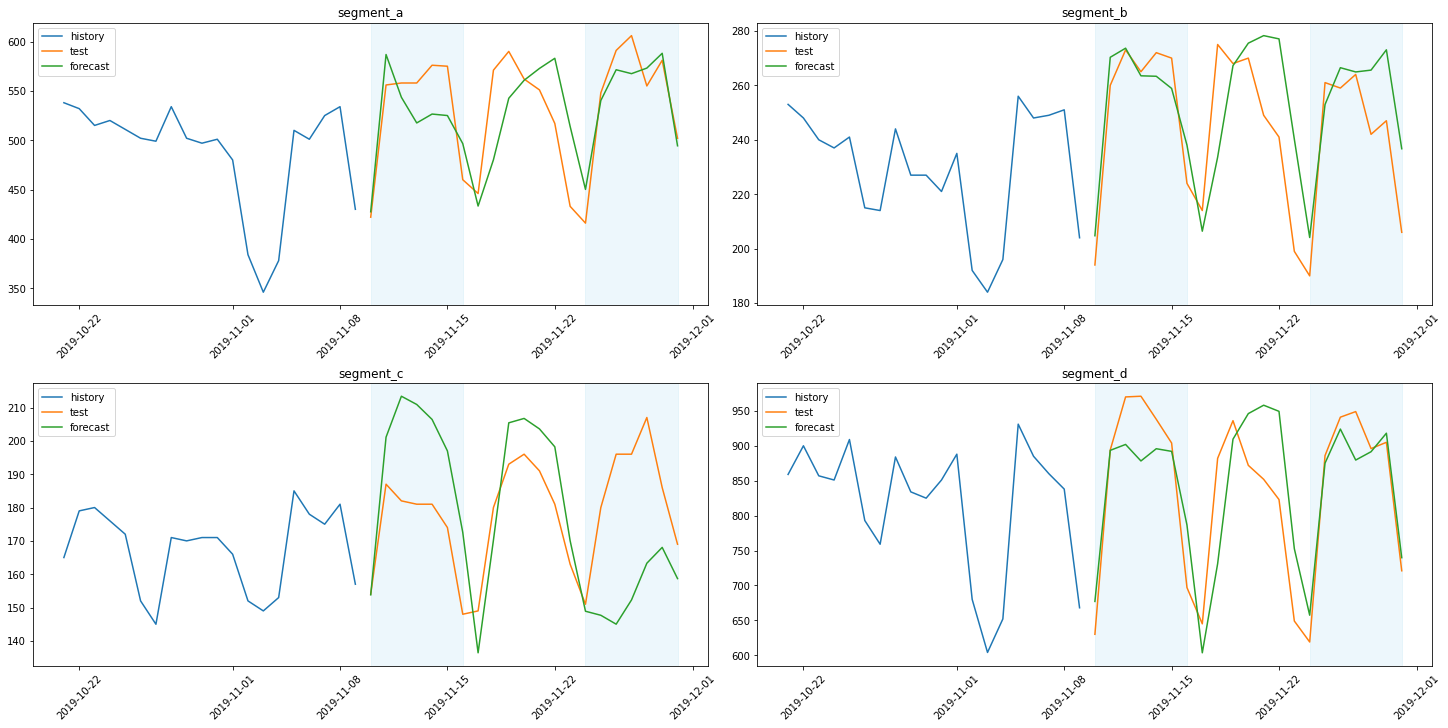

In [6]:
plot_backtest(forecast, ts, history_len=20)

In [7]:
score = metrics["SMAPE"].mean()
print(f"Average SMAPE for LSTM: {score:.3f}")

Average SMAPE for LSTM: 7.712
